In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import StandardDataset as Dataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

pip install 'aif360[LFR]'
pip install 'aif360[AdversarialDebiasing]'


### Download two year dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

### Pre-processing

In [3]:
### Discard most features
df = df.copy().drop(columns=['id', 'name', 'first', 'last', 'compas_screening_date',
                                      'dob', 'age', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
                           'c_arrest_date','c_charge_desc','days_b_screening_arrest', 'decile_score',
                           'r_case_number', 'r_days_from_arrest', 'r_offense_date', 'c_days_from_compas',
                           'r_charge_degree', 'r_charge_desc', 'r_jail_in', 'r_jail_out','priors_count.1',
                           'violent_recid', 'is_violent_recid', 'vr_case_number', 
                           'vr_charge_degree', 'vr_offense_date', 'vr_case_number',
                           'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 
                           'type_of_assessment', 'decile_score.1', 'score_text', 'is_recid',
                           'v_type_of_assessment', 'screening_date', 'v_decile_score',
                           'v_score_text', 'v_screening_date', 'in_custody', 'out_custody',
                           'event'])

### Keep only whites and blacks
race_map = {'African-American':0., 'Caucasian':1., 'Asian':2., 'Hispanic':3., 'Native American':4., 'Other':5.
}

df['race'] = df['race'].apply(lambda x: race_map[x])
df = df[(df.race == 0.) | (df.race == 1.)]

### Categorize age
df['age_cat'] = df['age_cat'].apply(lambda x: 0. if x=='Less than 25' else 1. if x=='25 - 45' else 2.)

### Convert sex to 0-1
df['sex'] = df['sex'].apply(lambda x: 0. if x=='Male' else 1.)

### Convert charge degree to 0-1
df['c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 1. if x=='F' else 0.)

### Construct duration column
df['duration'] = df.end - df.start
df = df.drop(columns=['end', 'start'])

### Target variable is if released prisoner recomitted crime
X = df.drop(columns=['two_year_recid']).values
y = df['two_year_recid'].values

### Rescale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid,duration
1,0.0,1.0,0.0,0,0,0,0,1.0,1,150
2,0.0,0.0,0.0,0,0,1,4,1.0,1,63
3,0.0,0.0,0.0,0,1,0,1,1.0,0,1174
6,0.0,1.0,1.0,0,0,0,14,1.0,1,35
8,1.0,1.0,1.0,0,0,0,0,0.0,0,745


### Training

In [4]:
### Split to train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Fit logistic regression and print accuracy
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy =", np.round(acc, 3))

Accuracy = 0.873


### Percentage of recidivism

In [5]:
print("Percentage of recidivism in test set:", np.round(np.mean(y_test), 3))

Percentage of recidivism in test set: 0.471


### Let's compare the ratio of African-American to Caucasians in the original data and the same ratio in the predicted reoffenses (demographic parity metric)

In [6]:
afr_am_to_whites_ratio = np.sum(df['race'].values == 0.) / np.sum(df['race'].values == 1.)
print("Black to white prisoners ratio:", np.round(afr_am_to_whites_ratio, 2))

Black to white prisoners ratio: 1.51


### Let's see the same ratio on the predicted outcomes

In [7]:
# Predict on test

# 3rd column is race
afr_am = np.isclose(X_test[:, 2], 0.)
white = np.isclose(X_test[:, 2], 1.)

pred_afr_am = y_pred[afr_am]
pred_white = y_pred[white]

afr_am_to_whites_ratio = np.sum(afr_am) / np.sum(white)
predicted_reoffense_afr_am_to_whites_ratio = np.sum(pred_afr_am) / np.sum(pred_white)

print("Black to white prisoners ratio:", np.round(afr_am_to_whites_ratio, 2))
print("Predicted reoffense blacks to whites ratio:", np.round(predicted_reoffense_afr_am_to_whites_ratio, 2))

Black to white prisoners ratio: 1.52
Predicted reoffense blacks to whites ratio: 2.18


### Check the coefficients to identify the most important predictive variables

In [8]:
clf.coef_

array([[-0.14923354, -0.77276445, -0.17726532,  0.92978236,  0.40985674,
         0.82888595,  1.8915404 , -0.25321452, -8.83930509]])

### We can clearly see that the coefficients corresponding to captivity duration and prior offenses count are the best predictors of recidivism. This is good since these should not contain much bias

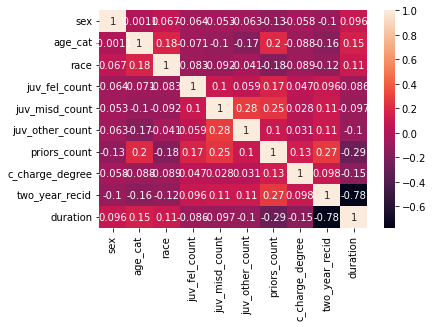

In [9]:
corr_matrix = df.corr()

sn.heatmap(corr_matrix, annot=True)
plt.show()

### Implement Disparate Impact Repairing

In [10]:
protected = 'race'
cd = Dataset(df,
             label_name='two_year_recid',
             favorable_classes=[0],
             protected_attribute_names=[protected],
             privileged_classes=[[1]], categorical_features=[],   # 0 -> Black, 1 -> White
             features_to_keep=['race', 'priors_count', 'duration'])

In [11]:
scaler = MinMaxScaler(copy=False)

test, train = cd.split([0.33], seed=42)
train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index(protected)

### Try out 10 different repair levels between 0 and 1

In [12]:
DIs = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(train)
    test_repd = di.fit_transform(test)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    p = [{protected: 1}]
    u = [{protected: 0}]
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.15it/s]


### Plot

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24996\3139045373.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


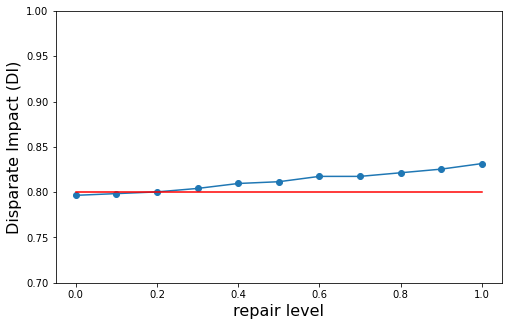

In [13]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.7, 1.])
plt.ylabel('Disparate Impact (DI)', fontsize=16)
plt.xlabel('repair level',fontsize=16)
plt.savefig('DisparateImpact.png')
plt.show()

### Let's see how the model is doing now on predicted recidivism blacks to whites ratio

In [14]:
# Predict on test
y_pred = lmod.predict(X_test[:, [-3, -1]])

# 3rd column is race
afr_am = np.isclose(X_test[:, 2], 0.)
white = np.isclose(X_test[:, 2], 1.)

pred_afr_am = y_pred[afr_am]
pred_white = y_pred[white]

afr_am_to_whites_ratio = np.sum(afr_am) / np.sum(white)
predicted_reoffense_afr_am_to_whites_ratio = np.sum(pred_afr_am) / np.sum(pred_white)

print("Black to white prisoners ratio:", np.round(afr_am_to_whites_ratio, 2))
print("Predicted reoffense blacks to whites ratio:", np.round(predicted_reoffense_afr_am_to_whites_ratio, 2))

Black to white prisoners ratio: 1.52
Predicted reoffense blacks to whites ratio: 2.11


### We can see that the ratio has dropped, which means we have mitigated some bias!

In [15]:
privileged_groups = [{'race': 1.}]
unprivileged_groups = [{'race': 0.}]

In [16]:
metric_orig_train = BinaryLabelDatasetMetric(train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between blacks and whites = %f" % metric_orig_train.mean_difference())

Difference in mean outcomes between blacks and whites = -0.125928


In [17]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train)
transf_train = RW.transform(train)

In [18]:
### Testing 
np.abs(transf_train.instance_weights.sum()-train.instance_weights.sum())<1e-6

True

### Metric with the transformed training data

In [19]:
metric_transf_train = BinaryLabelDatasetMetric(transf_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between transformed blacks and whites = %f" % metric_transf_train.mean_difference())

Difference in mean outcomes between transformed blacks and whites = -0.000000


### Train Logistic Regression with reweighed dataset

In [20]:
scale_transf = StandardScaler()
X_reweighed_train = scale_transf.fit_transform(transf_train.features)
y_reweighed_train = transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_reweighed_train, y_reweighed_train,
        sample_weight=transf_train.instance_weights)
y_train_pred = lmod.predict(X_reweighed_train)

In [21]:
transf_test = RW.transform(test)

scale_transf = StandardScaler()
X_reweighed_test = scale_transf.fit_transform(transf_test.features)
y_reweighed_test = transf_test.labels.ravel()

# Predict on test
y_pred = lmod.predict(X_reweighed_test)

# 3rd column is race
afr_am = np.isclose(X_test[:, 2], 0.)
white = np.isclose(X_test[:, 2], 1.)

pred_afr_am = y_pred[afr_am[:-1]]
pred_white = y_pred[white[:-1]]

afr_am_to_whites_ratio = np.sum(afr_am) / np.sum(white)
predicted_reoffense_afr_am_to_whites_ratio = np.sum(pred_afr_am) / np.sum(pred_white)

print("Black to white prisoners ratio:", np.round(afr_am_to_whites_ratio, 2))
print("Predicted reoffense blacks to whites ratio:", np.round(predicted_reoffense_afr_am_to_whites_ratio, 2))

Black to white prisoners ratio: 1.52
Predicted reoffense blacks to whites ratio: 1.5


### Ratio unfairness is fixed, let's see this classifier's accuracy

In [22]:
y_pred = lmod.predict(X_reweighed_test)

acc = np.sum(y_pred == y_reweighed_test) / len(y_reweighed_test)
print("Accuracy =", np.round(acc, 3))

Accuracy = 0.875


### Great! Let's see if reweighing has affected disparate impact

In [23]:
p = [{protected: 1}]
u = [{protected: 0}]
cm = BinaryLabelDatasetMetric(transf_test.copy(), privileged_groups=p, unprivileged_groups=u)
DIs.append(cm.disparate_impact())

### Plot the new DIs

C:\Users\Administrator\AppData\Local\Temp\ipykernel_24996\2591635188.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


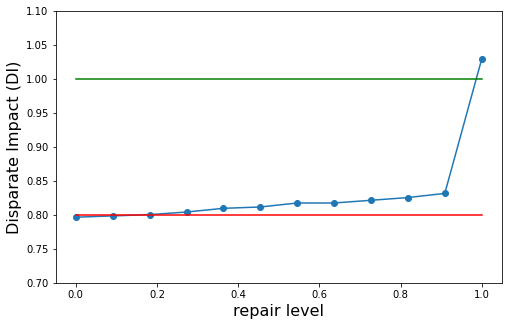

In [24]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(0, 1, 12), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.7, 1.1])
plt.ylabel('Disparate Impact (DI)', fontsize=16)
plt.xlabel('repair level',fontsize=16)
plt.savefig('DisparateImpactFixed.png')
plt.show()

### Now we move on to Reject Option Classification

In [26]:
pos_ind = np.where(lmod.classes_ == transf_train.favorable_label)[0][0]

transf_train_post = transf_train.copy(deepcopy=True)
X_reweighed_train_post = scale_transf.fit_transform(transf_train_post.features)
y_train_post = transf_train_post.labels
transf_train_post.scores = lmod.predict_proba(X_reweighed_train_post)[:,pos_ind].reshape(-1,1)

transf_test_post = transf_test.copy(deepcopy=True)
X_reweighed_test_post = scale_transf.fit_transform(transf_test_post.features)
y_test_post = transf_test_post.labels
transf_test_post.scores = lmod.predict_proba(X_reweighed_test_post)[:,pos_ind].reshape(-1,1)

In [27]:
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

metric_ub = 0.05
metric_lb = -0.05

ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name= 'Statistical parity difference',
                                  metric_ub=metric_ub, metric_lb=metric_lb)
                                  
ROC = ROC.fit(transf_test, transf_test_post)

In [28]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.8316
Optimal ROC margin = 0.0069


In [29]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [30]:
# Metrics for the transformed test set
dataset_transf_test_post = ROC.predict(transf_test_post)

In [31]:
metric_test_aft = compute_metrics(transf_test, dataset_transf_test_post, 
                unprivileged_groups, privileged_groups)

Balanced accuracy = 0.8963
Statistical parity difference = -0.0099
Disparate impact = 0.9777
Average odds difference = -0.0205
Equal opportunity difference = -0.0413
Theil index = 0.1155


### This concludes our bias mitigation efforts. We can safely say we have achieved a fairly fair model.